# Computing stress from IRGASON over all experiments

This notebook puts together stress calculations from IRGASON over all SUSTAIN drag runs to date.

In [34]:
from asist.utility import power_spectrum
from datetime import datetime, timedelta
import glob
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.signal import detrend
from scipy.stats import beta
from sustain_drag_2020.irgason import read_irgason_from_toa5, rotate
from sustain_drag_2020.udm import read_udm_from_toa5
from sustain_drag_2020.fetch import fetch
from sustain_drag_2020.dispersion import w2k
import warnings
warnings.filterwarnings('ignore')

In [35]:
def diffc(x):
    """Finite difference centered in space."""
    xx = np.zeros((x.size))
    xx[1:-1] = (x[2:] - x[:-2]) / 2
    xx[0] = x[1] - x[0]
    xx[-1] = x[-1] - x[-2]
    return xx

## Eddy-covariance flux calculation

* Takes into account IRGASON's diagnostic flag to remove bad data;
* Rotates the IRGASON in the $x-z$ plane based on arc tangent of $\overline{u}$ and $\overline{w}$;
* For each EC sample, it also returns the percentage of good $u'w'$ data which we can use in quality control to discard untrusty flux data

In [36]:
def eddy_covariance_flux(irg, time, t0, t1):
    """Eddy covariance flux from IRGASON, for a time subset between t0 and t1."""
    mask = (time >= t0) & (time <= t1)
    u, v, w = irg['u'][mask][:], irg['v'][mask][:], irg['w'][mask][:]
    u = np.sqrt(u**2 + v**2) # horizontal velocity
    angle = np.arctan2(np.nanmean(w), np.nanmean(u))
    u, w = rotate(u, w, angle)
    U, W = np.nanmean(u), np.nanmean(w) # time mean
    up, wp = u - U, w - W # deviations from the mean
    uw = np.nanmean(up * wp) # stress
    good = ~np.isnan(u) & ~np.isnan(w)
    perc_good = (u[good].size / u.size) * 100
    return U, uw, perc_good

In [37]:
def read_irgason_for_experiment(path):
    """A thin wrapper around read_irgason_from_toa5()."""
    irgason_files = glob.glob(path + '/TOA5_SUSTAIN_Wind.FAST*.dat')
    return read_irgason_from_toa5(irgason_files, valid_flag=11)

## Wind and stress data

### Experiments

Date       | Start time (UTC) | Run length (s) | Water depth (m) | Fresh/seawater | Fan [Hz] | Paddle | IRGASON | UDM | Wave wires | Pressure | Hot film | Air temperature | Water temperature
-----------|------------------|----------------|-----------------|----------------|----------|--------|---------|-----|------------|----------|----------|-----------------|------------------
2019-11-14 | 19:20:00 | 600 | 0.80 | Mixed | 0 - 15 | No | ✔ | ✔ |   |   | | |
2019-11-21 | 16:10:00 | 600 | 0.80 | Fresh | 0 - 60 | No | ✔ | ✔ | ✔ |   | | |
2019-12-03 | 17:30:00 | 600 | 0.80 | Fresh | 0 - 50 | No | ✔ | ✔ | ✔ | ✔ | | | 
2020-01-09 | 19:36:00 | 600 | 0.75 | Salt  | 0 - 60 | JONSWAP, Hs = 0.15 m, Tp = 1 s, cos^2 spread | ✔ | ✔ | ✔ | ✔ | ✔ (1.35 m) | 24.8 - 29.5 C | 19.9 - 20.6 C 
2020-01-10 | 02:40:00 | 600 | 0.75 | Salt  | 0 - 60 | JONSWAP, Hs = 0.15 m, Tp = 1 s, cos^2 spread | ✔ | ✔ | ✔ | ✔ | ✔ (1.35 m) | 25.8 - 27.5 C | 31.0 - 27.0 C 
2020-01-10 | 19:48:00 | 600 | 0.75 | Salt  | 0 - 60 | Monochromatic, a = 0.15 m, Tp = 1 s | ✔ | ✔ | ✔ | ✔ |  | 27.7 - 30.0 C | 33.7 - 29.5 C 
2020-01-22 | 18:00:00 | 600 | 0.81 | Fresh  | 0, 10, 20 | No | ✔ | ✔ | ✔ | ✔ | ✔ (0.90 m) | | 17.6 C
2020-01-27 | 21:07:00 | 600 | 0.75 | Salt  | 0 - 60 | Monochromatic, a = 0.15 m, Tp = 1 s | ✔ | ✔ | ✔ | ✔ || | 

In [38]:
experiments = [
    {'start_time': datetime(2019, 11, 14, 19, 20), 'fan': range(0, 20, 5)}, # wind only, 0-15 Hz, fresh water
    {'start_time': datetime(2019, 11, 21, 16, 10), 'fan': range(0, 55, 5)}, # wind only, 0-60 Hz, fresh water
    {'start_time': datetime(2019, 12,  3, 17, 30), 'fan': range(0, 55, 5)}, # wind only, 0-50 Hz, fresh water
    {'start_time': datetime(2020,  1,  9, 19, 36), 'fan': range(0, 55, 5)}, # wind + JONSWAP, 0-60 Hz, seawater, stable
    {'start_time': datetime(2020,  1, 10,  2, 40), 'fan': range(0, 55, 5)}, # wind + JONSWAP, 0-60 Hz, seawater, unstable
    #{'start_time': datetime(2020,  1, 10, 19, 48), 'fan': range(0, 55, 5)}, # wind + monochromatic, 0-60 Hz, seawater, unstable 
    #{'start_time': datetime(2020,  1, 27, 21,  7), 'fan': range(0, 65, 5)}, # wind + monochromatic, 0-60 Hz, seawater, stable
]

### Loading raw data from files

In [40]:
DATAPATH = '/Users/sustain100d-guest/Downloads/sustain-drag-2020'

for exp in experiments:
    print(exp['start_time'])
    exp['data'] = read_irgason_for_experiment(DATAPATH + '/' + exp['start_time'].strftime('%Y%m%d'))

2019-11-14 19:20:00
Reading  TOA5_SUSTAIN_Wind.FAST_470_2019_11_14_1900.dat
Processing IRGASON time series..
2019-11-21 16:10:00
Reading  TOA5_SUSTAIN_Wind.FAST_635_2019_11_21_1600.dat
Reading  TOA5_SUSTAIN_Wind.FAST_636_2019_11_21_1700.dat
Reading  TOA5_SUSTAIN_Wind.FAST_637_2019_11_21_1800.dat
Processing IRGASON time series..
2019-12-03 17:30:00
Reading  TOA5_SUSTAIN_Wind.FAST_757_2019_12_03_1700.dat
Reading  TOA5_SUSTAIN_Wind.FAST_758_2019_12_03_1800.dat
Reading  TOA5_SUSTAIN_Wind.FAST_759_2019_12_03_1900.dat
Processing IRGASON time series..
2020-01-09 19:36:00
Reading  TOA5_SUSTAIN_Wind.FAST_3_2020_01_09_1900.dat
Reading  TOA5_SUSTAIN_Wind.FAST_4_2020_01_09_2000.dat
Reading  TOA5_SUSTAIN_Wind.FAST_5_2020_01_09_2100.dat
Processing IRGASON time series..
2020-01-10 02:40:00
Reading  TOA5_SUSTAIN_Wind.FAST_10_2020_01_10_0200.dat
Reading  TOA5_SUSTAIN_Wind.FAST_11_2020_01_10_0300.dat
Reading  TOA5_SUSTAIN_Wind.FAST_12_2020_01_10_0400.dat
Reading  TOA5_SUSTAIN_Wind.FAST_27_2020_01_10_190

## Random sampling with uniform distribution

It's common practice (it seems to me) to sample the $-\overline{u'w'}$ flux sequentially over the time series. For example, if you have 10 minutes of data and choose 1 minute as the averaging period, then you collect 10 samples in sequence. This sampling is deterministic--you get the same result every time you compute the flux, which is an advantage. A downside are that you can potentially have a bias in the flux if the time-series aren't completely stationary--a single sample can "happen" to cover a non-transient feature of the flow. Another downside is that you're limited in how many samples you can compute.   

Alternatively, we can sample the time series randomly, with a uniform distribution. If we collect many enough samples, even if they overlap, we can be sure not to introduce bias from non-transient features. Further, this also allows us to "oversample" the time series and construct a more-or-less continuous distribution of flux.

In [41]:
def sample_stress_uniform(irgason_data, time, start_time, run_seconds, sample_seconds, sampling):
    """Uniform-randomly sample IRGASON data and compute stress over given sample intervals."""
    num_runs, num_samples = sampling.shape
    U = np.zeros(sampling.shape)
    uw = np.zeros(sampling.shape)
    perc_good = np.zeros((num_runs, num_samples))
    for n in range(num_runs):
        #print('Computing stress for run', n)
        for i in range(num_samples):
            t0 = start_time + timedelta(seconds=n * run_seconds + sampling[n,i])
            t1 = t0 + timedelta(seconds=sample_seconds)
            U[n,i], uw[n,i], perc_good[n,i] = eddy_covariance_flux(irgason_data, time, t0, t1)
    return U, uw, perc_good

## Sample the IRGASON data to compute flux

Here we do the actual sampling. We pick the size of each sample in seconds, and how many samples to collect.
Then we draw start times from a uniform distribution.

In [42]:
sample_seconds = 60
run_seconds = 600
num_samples = 20

for n, exp in enumerate(experiments):
    num_runs = len(exp['fan'])
    print('exp', n, num_runs)
    sampling = np.random.uniform(size=(num_runs, num_samples)) * (run_seconds - sample_seconds)
    time, irg1, irg2 = exp['data']
    exp['U1'], exp['uw1'], exp['perc_good1'] = sample_stress_uniform(irg1, time, exp['start_time'], run_seconds, sample_seconds, sampling)
    exp['U2'], exp['uw2'], exp['perc_good2'] = sample_stress_uniform(irg2, time, exp['start_time'], run_seconds, sample_seconds, sampling)
    exp['sampling'] = sampling

exp 0 4
exp 1 11
exp 2 11
exp 3 11
exp 4 11


Text(0.5, 0.98, 'Wind only')

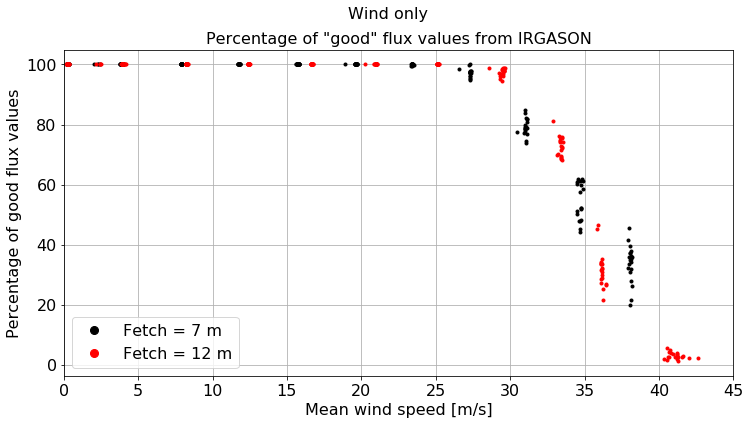

In [43]:
n = 2 # wind only

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, xlim=(0, 45))
ax.tick_params(axis='both', labelsize=16)
plt.plot(experiments[n]['U1'], experiments[n]['perc_good1'], 'k.')
plt.plot(experiments[n]['U2'], experiments[n]['perc_good2'], 'r.')
plt.plot(np.nan, np.nan, 'ko', label='Fetch = 7 m', ms=8)
plt.plot(np.nan, np.nan, 'ro', label='Fetch = 12 m', ms=8)
plt.legend(loc='lower left', prop={'size': 16})
plt.grid()
plt.xlabel('Mean wind speed [m/s]', fontsize=16)
plt.ylabel('Percentage of good flux values', fontsize=16)
plt.title('Percentage of "good" flux values from IRGASON', fontsize=16)
fig.suptitle('Wind only', fontsize=16)

Text(0.5, 0.98, 'Wind + JONSWAP')

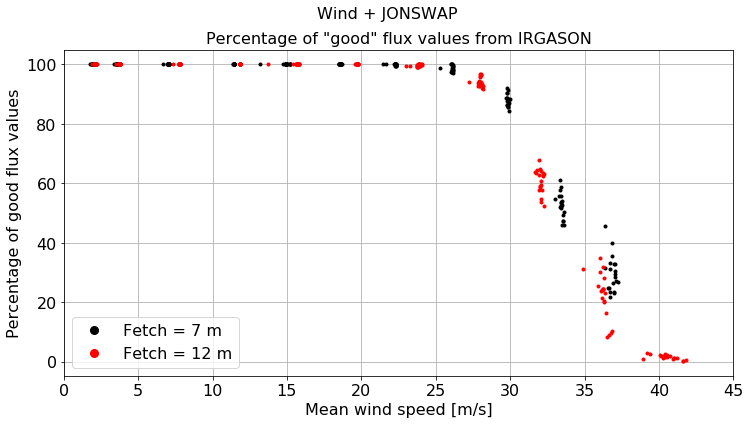

In [44]:
n = 3 # wind + JONSWAP

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, xlim=(0, 45))
ax.tick_params(axis='both', labelsize=16)
plt.plot(experiments[n]['U1'], experiments[n]['perc_good1'], 'k.')
plt.plot(experiments[n]['U2'], experiments[n]['perc_good2'], 'r.')
plt.plot(np.nan, np.nan, 'ko', label='Fetch = 7 m', ms=8)
plt.plot(np.nan, np.nan, 'ro', label='Fetch = 12 m', ms=8)
plt.legend(loc='lower left', prop={'size': 16})
plt.grid()
plt.xlabel('Mean wind speed [m/s]', fontsize=16)
plt.ylabel('Percentage of good flux values', fontsize=16)
plt.title('Percentage of "good" flux values from IRGASON', fontsize=16)
fig.suptitle('Wind + JONSWAP', fontsize=16)

## IRGASON quality control takeaways

* In wind-only conditions, data begins to degrade beyond $U_z > 25\ m/s$, and completely degraded at $U_z \approx 40\ m/s$;
* In wind + JONSWAP conditions, similar as in wind-only;
* In wind + monochromatic waves, data begins to degrade beyond $U_z > 20\ m/s$, with higher sensitivity to fetch.

=> We can use this information to mask out the data where we don't trust it, for example, if less than 99% of data was good.

In [45]:
# mask out data where less than 99% of data was good
for n, exp in enumerate(experiments):
    num_runs = len(exp['fan'])
    for nrun in range(num_runs):
        good1 = exp['perc_good1'][nrun,:] > 99
        good2 = exp['perc_good2'][nrun,:] > 99
        exp['U1'][nrun,:][~good1] = np.nan
        exp['U2'][nrun,:][~good2] = np.nan
        exp['uw1'][nrun,:][~good1] = np.nan
        exp['uw2'][nrun,:][~good2] = np.nan

In [46]:
labels = [
    'Wind only, neutral',
    'Wind only, neutral',
    'Wind only, neutral',
    'JONSWAP, stable',
    'JONSWAP, unstable',
    #'Monochromatic, unstable'
]

colors = ['k', 'b', 'g', 'y', 'r'] #'m']

## Momentum flux as function of mean wind speed

Text(0.5, 1.0, 'Momentum flux from IRGASON, fetch = 7 m')

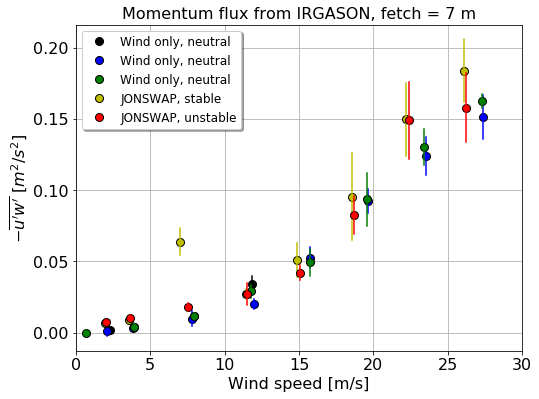

In [47]:
irgnum = '1'

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlim=(0, 30))
ax.tick_params(axis='both', labelsize=16)

for n, exp in enumerate(experiments):
    plt.plot(np.nan, np.nan, colors[n] + 'o', mec='k', ms=8, label=labels[n])
    for m, fan in enumerate(exp['fan']):
        U_mean, uw_mean = np.nanmean(exp['U' + irgnum][m]), np.nanmean(exp['uw' + irgnum][m])
        U_std, uw_std = np.nanstd(exp['U' + irgnum][m]), np.nanstd(exp['uw' + irgnum][m])
        plt.plot(U_mean, uw_mean, colors[n] + 'o', mec='k', ms=8)
        plt.plot([U_mean, U_mean], [uw_mean - uw_std, uw_mean + uw_std], colors[n] + '-')

plt.legend(loc='upper left', fancybox=True, shadow=True, prop={'size': 12})
plt.grid()
plt.xlabel('Wind speed [m/s]', fontsize=16)
plt.ylabel(r"$-\overline{u'w'}$ [$m^2/s^2$]", fontsize=16)
plt.title('Momentum flux from IRGASON, fetch = 7 m', fontsize=16)

Text(0.5, 1.0, 'Momentum flux from IRGASON, fetch = 12 m')

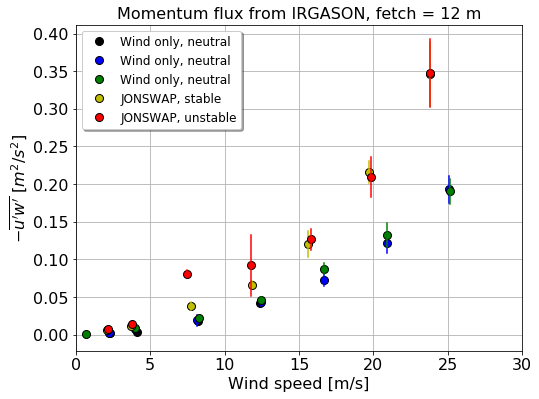

In [48]:
irgnum = '2'

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlim=(0, 30))
ax.tick_params(axis='both', labelsize=16)

for n, exp in enumerate(experiments):
    plt.plot(np.nan, np.nan, colors[n] + 'o', mec='k', ms=8, label=labels[n])
    for m, fan in enumerate(exp['fan']):
        U_mean, uw_mean = np.nanmean(exp['U' + irgnum][m]), np.nanmean(exp['uw' + irgnum][m])
        U_std, uw_std = np.nanstd(exp['U' + irgnum][m]), np.nanstd(exp['uw' + irgnum][m])
        plt.plot(U_mean, uw_mean, colors[n] + 'o', mec='k', ms=8)
        plt.plot([U_mean, U_mean], [uw_mean - uw_std, uw_mean + uw_std], colors[n] + '-')

plt.legend(loc='upper left', fancybox=True, shadow=True, prop={'size': 12})
plt.grid()
plt.xlabel('Wind speed [m/s]', fontsize=16)
plt.ylabel(r"$-\overline{u'w'}$ [$m^2/s^2$]", fontsize=16)
plt.title('Momentum flux from IRGASON, fetch = 12 m', fontsize=16)

## Adjusting the stress to the surface

Currently, our stress measurements are valid at the height of the measurement.
Stress is not necessarily constant in the tank like it is in the lower boundary layer of the atmosphere.
We'll use the along-tank pressure gradient as a proxy for vertical stress gradient to extrapolate our stress measurements to the surface.

### Along-tank pressure gradient

In [50]:
pexperiments = [
    {'name': 'windonly_neutral', 'start_time': datetime(2019, 12, 3, 17, 30)},
    {'name': 'jonswap_stable', 'start_time': datetime(2020, 1, 9, 19, 36)},
    {'name': 'jonswap_unstable', 'start_time': datetime(2020, 1, 10, 2, 40)},
    #{'name': 'monochromatic_unstable', 'start_time': datetime(2020, 1, 10, 19, 48)},
    #{'name': 'monochromatic_stable', start_time = datetime(2020, 1, 27, 21, 7)},
]

data = pd.read_csv(DATAPATH + '/scanivalve/scanivalve_' + pexperiments[2]['name'] + '.csv')
time = data['FTime']

fan = range(0, 55, 5)
x = fetch['static_pressure']
run_seconds = 600

start_time = datetime(2019, 12, 3, 17, 30)

### Static pressure time series along the tank

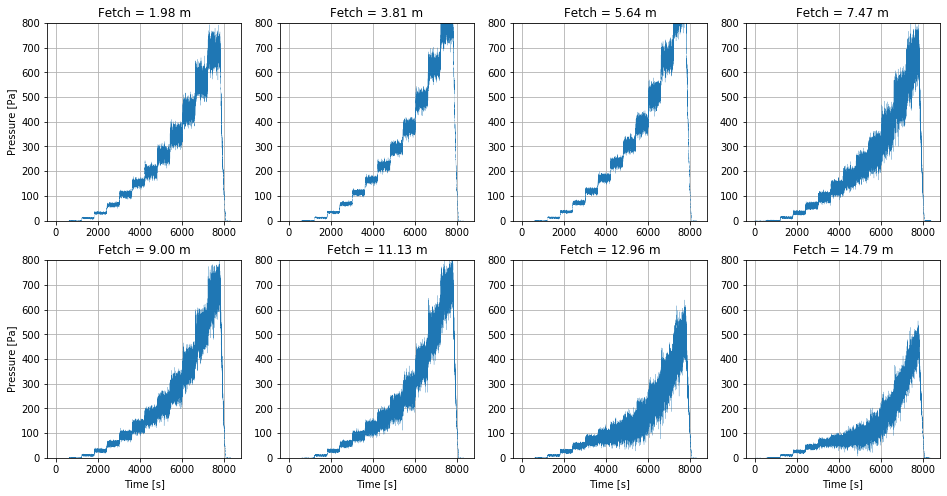

In [51]:
fig = plt.figure(figsize=(16, 8))
for j in range(2):
    for i in range(4):
        ax = plt.subplot2grid((2, 4), (j, i))
        pressure_index = j * 4 + i + 1
        ax.plot(time, data['%2.2i' % pressure_index + 'Press'], lw=0.2)
        plt.title('Fetch = %.2f m' % x[pressure_index - 1])
        plt.grid(True)
        plt.ylim(0, 800)
        if i == 0: plt.ylabel('Pressure [Pa]')
        if j == 1: plt.xlabel('Time [s]')

### Time-average pressure by run

In [52]:
labels = [
    'wind only, neutral',
    'JONSWAP, stable',
    'JONSWAP, unstable',
    #'Monochromatic, unstable'
]

colors = ['g', 'y', 'r']#, 'm']

plotting exp windonly_neutral
plotting exp jonswap_stable
plotting exp jonswap_unstable


Text(0.5, 0.98, 'Static pressure, ceiling, as function of fetch and experiment')

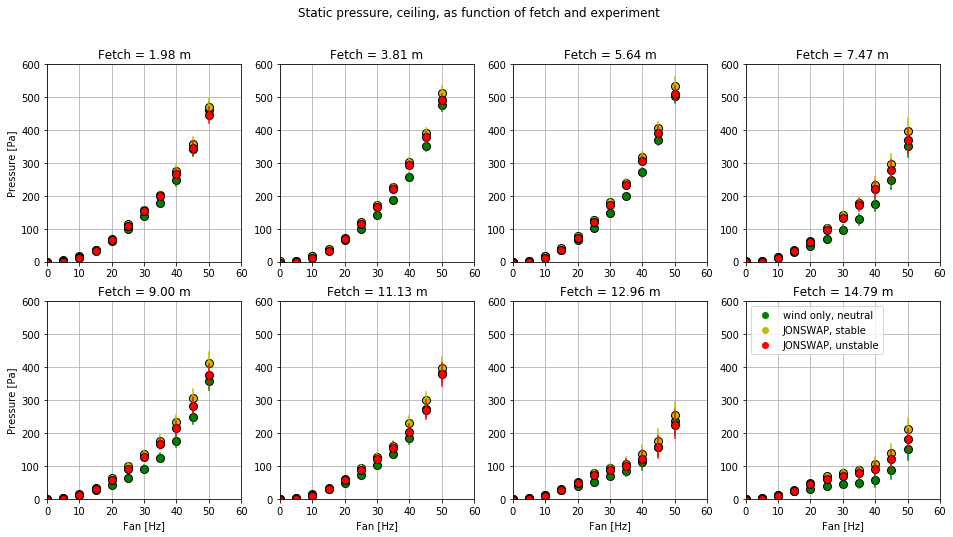

In [53]:
fan = range(0, 55, 5)

# 9-minute time windows for each run; 
# we exclude the first minute (thus 9 and not 10) due to fan spinup
t0 = [n * run_seconds + 60 for n in range(len(fan))]
t1 = [(n + 1) * run_seconds for n in range(len(fan))]

fig = plt.figure(figsize=(16, 8))
axes = []
for j in range(2):
    for i in range(4):
        ax = plt.subplot2grid((2, 4), (j, i))
        axes.append(ax)
        plt.grid(True)
        plt.xlim(0, 60)
        plt.ylim(0, 600)
        if i == 0: plt.ylabel('Pressure [Pa]')
        if j == 1: plt.xlabel('Fan [Hz]')
            
for nexp, pexp in enumerate(pexperiments):

    print('plotting exp ' + pexp['name'])
    data = pd.read_csv(DATAPATH + '/scanivalve/scanivalve_' + pexp['name'] + '.csv')
    time = data['FTime']
    
    for j in range(2):
        for i in range(4):
            ax = axes[j * 4 + i]
            pressure_index = j * 4 + i + 1
            pmean, pstd = [], []
            for n in range(len(fan)):
                mask = (time >= t0[n]) & (time <= t1[n])
                pres = data['%2.2iPress' % pressure_index][mask]
                pmean.append(np.mean(pres))
                pstd.append(np.std(pres))
            ax.plot(fan, pmean, marker='o', color=colors[nexp], ms=8, mec='k', linestyle='')
            for n in range(len(fan)):
                ax.plot([fan[n], fan[n]], [pmean[n] - pstd[n], pmean[n] + pstd[n]], color=colors[nexp])
            ax.set_title('Fetch = %.2f m' % x[pressure_index - 1])

ax = axes[-1]
for nexp, pexp in enumerate(pexperiments):
    ax.plot(np.nan, np.nan, colors[nexp] + 'o', label=labels[nexp])
ax.legend(loc='upper left')

fig.suptitle('Static pressure, ceiling, as function of fetch and experiment')

### Calculating the mean along-tank pressure slope

In [54]:
pmean = np.zeros((len(pexperiments), len(fan), 8))
pstd = np.zeros((len(pexperiments), len(fan), 8))
for i in range(8):
    for nexp, pexp in enumerate(pexperiments):
        data = pd.read_csv(DATAPATH + '/scanivalve/scanivalve_' + pexp['name'] + '.csv')
        time = data['FTime']
        for nrun, runs in enumerate(fan):
            mask = (time >= t0[nrun]) & (time <= t1[nrun])
            pres = data['%2.2iPress' % (i + 1)][mask]
            pmean[nexp,nrun,i] = np.mean(pres)
            pstd[nexp,nrun,i] = np.std(pres)

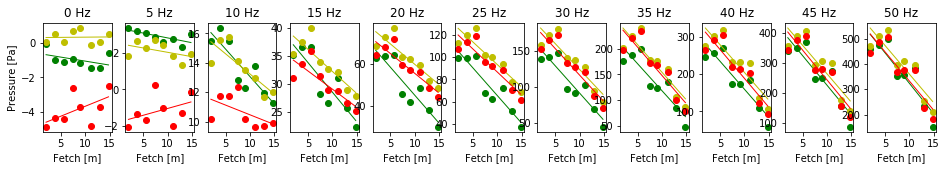

In [55]:
fig = plt.figure(figsize=(16, 2))
dpdx = np.zeros((len(pexperiments), len(fan)))
for n in range(len(fan)):
    ax = plt.subplot2grid((1, len(fan)), (0, n))
    for nexp, pexp in enumerate(pexperiments):
        plt.plot(x, pmean[nexp,n,:], colors[nexp] + 'o')
        p = np.polyfit(x, pmean[nexp,n,:], 1)
        fit = np.polyval(p, x)
        plt.plot(x, fit, colors[nexp] + '-', lw=1)
        plt.xlabel('Fetch [m]')
        if n == 0: plt.ylabel('Pressure [Pa]')
        plt.title(str(fan[n]) + ' Hz')
        dpdx[nexp, n] = (fit[-1] - fit[0]) / (x[-1] - x[0])

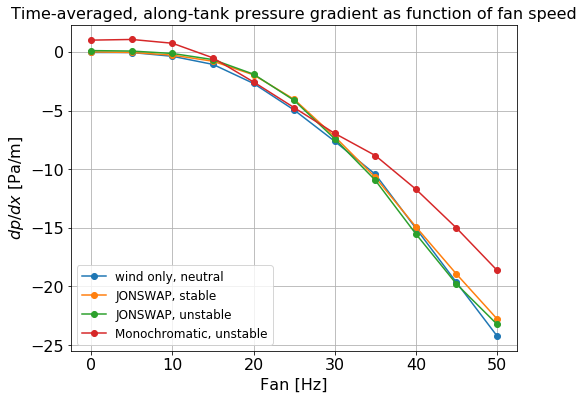

In [25]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.tick_params(axis='both', labelsize=16)
for nexp, pexp in enumerate(pexperiments):
    plt.plot(fan, dpdx[nexp,:], marker='o', label=labels[nexp])
plt.legend(loc='lower left', prop={'size': 12})
plt.xlabel('Fan [Hz]', fontsize=16)
plt.ylabel(r'$dp/dx$ [Pa/m]', fontsize=16)
plt.title('Time-averaged, along-tank pressure gradient as function of fan speed', fontsize=16)
plt.grid()

## Correcting stress to the surface

In [56]:
z_surface = 0.75
z_irgason = 1.35

dtaudz = 1.5 * 13 / 20 * dpdx # first guess based on HIDRAG data

In [57]:
labels = [
    'wind only, neutral',
    'wind only, neutral',
    'wind only, neutral',
    'JONSWAP, stable',
    'JONSWAP, unstable',
    #'Monochromatic, unstable'
]

colors = ['k', 'b', 'g', 'y', 'r']#, 'm']

rhoa = 1.15

Text(0.5, 1.0, 'Stress from IRGASON, fetch = 7 m')

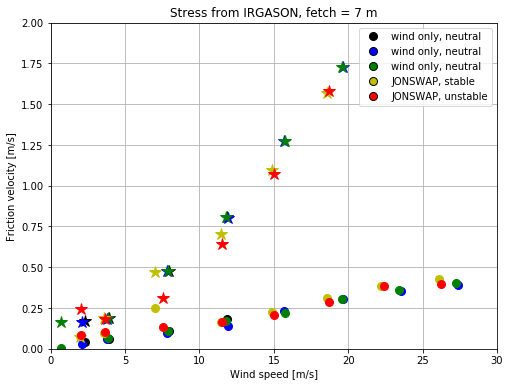

In [58]:
irgnum = '1'

fig = plt.figure(figsize=(8, 6))

for nexp, exp in enumerate(experiments):
    plt.plot(np.nan, np.nan, colors[nexp] + 'o', mec='k', ms=8, label=labels[nexp])
    for nrun, fan in enumerate(exp['fan']):
        Uz, uw = np.nanmean(exp['U' + irgnum][nrun]), np.nanmean(exp['uw' + irgnum][nrun])
        dtaudz_exp_index = 0 if nexp < 3 else nexp - 2
        uw_sfc = uw - dtaudz[dtaudz_exp_index, nrun] * (z_irgason - z_surface)
        ust = np.sqrt(np.abs(uw))
        ust_sfc = np.sqrt(np.abs(uw_sfc))
        plt.plot(Uz, ust, colors[nexp] + 'o', ms=8)
        plt.plot(Uz, ust_sfc, colors[nexp] + '*', ms=12)

plt.legend()
plt.grid()
plt.xlim(0, 30)
plt.ylim(0, 2)
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Friction velocity [m/s]')
plt.title('Stress from IRGASON, fetch = 7 m')

Text(0.5, 1.0, 'Stress from IRGASON, fetch = 12 m')

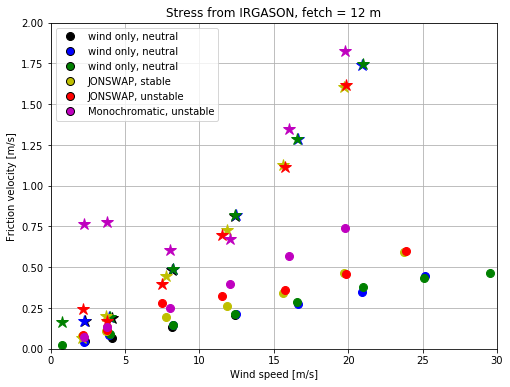

In [29]:
irgnum = '2'

fig = plt.figure(figsize=(8, 6))

for nexp, exp in enumerate(experiments):
    plt.plot(np.nan, np.nan, colors[nexp] + 'o', mec='k', ms=8, label=labels[nexp])
    for nrun, fan in enumerate(exp['fan']):
        Uz, uw = np.nanmean(exp['U' + irgnum][nrun]), np.nanmean(exp['uw' + irgnum][nrun])
        dtaudz_exp_index = 0 if nexp < 3 else nexp - 2
        uw_sfc = uw - dtaudz[dtaudz_exp_index, nrun] * (z_irgason - z_surface)
        ust = np.sqrt(np.abs(uw))
        ust_sfc = np.sqrt(np.abs(uw_sfc))
        plt.plot(Uz, ust, colors[nexp] + 'o', ms=8)
        plt.plot(Uz, ust_sfc, colors[nexp] + '*', ms=12)

plt.legend()
plt.grid()
plt.xlim(0, 30)
plt.ylim(0, 2)
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Friction velocity [m/s]')
plt.title('Stress from IRGASON, fetch = 12 m')

### Scale to 10-m reference height

In [59]:
def scale_to_height(ust, Uz, z, zref):
    """Scales wind Uz at height z to zref."""
    VON_KARMAN = 0.4
    return Uz + ust / VON_KARMAN * np.log(zref / z)

Text(0.5, 1.0, 'Stress from IRGASON, fetch = 7 m')

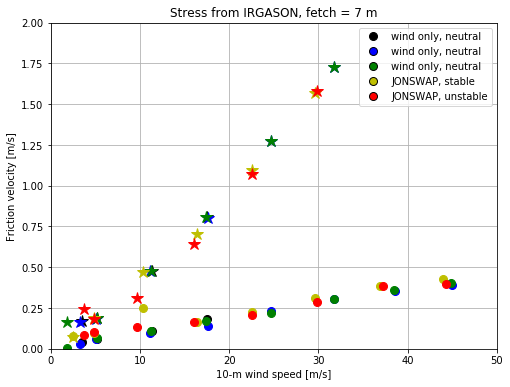

In [60]:
irgnum = '1'

fig = plt.figure(figsize=(8, 6))

for nexp, exp in enumerate(experiments):
    plt.plot(np.nan, np.nan, colors[nexp] + 'o', mec='k', ms=8, label=labels[nexp])
    for nrun, fan in enumerate(exp['fan']):
        Uz, uw = np.nanmean(exp['U' + irgnum][nrun]), np.nanmean(exp['uw' + irgnum][nrun])
        dtaudz_exp_index = 0 if nexp < 3 else nexp - 2
        uw_sfc = uw - dtaudz[dtaudz_exp_index, nrun] * (z_irgason - z_surface)
        ust = np.sqrt(np.abs(uw))
        ust_sfc = np.sqrt(np.abs(uw_sfc))
        U10 = scale_to_height(ust_sfc, Uz, z_irgason - z_surface, 10.)
        plt.plot(U10, ust, colors[nexp] + 'o', ms=8)
        plt.plot(U10, ust_sfc, colors[nexp] + '*', ms=12)

plt.legend()
plt.grid()
plt.xlim(0, 50)
plt.ylim(0, 2)
plt.xlabel('10-m wind speed [m/s]')
plt.ylabel('Friction velocity [m/s]')
plt.title('Stress from IRGASON, fetch = 7 m')

Text(0.5, 1.0, 'Stress from IRGASON, fetch = 12 m')

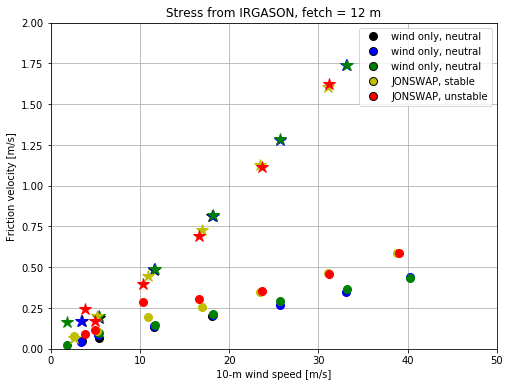

In [64]:
irgnum = '2'

fig = plt.figure(figsize=(8, 6))

for nexp, exp in enumerate(experiments):
    plt.plot(np.nan, np.nan, colors[nexp] + 'o', mec='k', ms=8, label=labels[nexp])
    for nrun, fan in enumerate(exp['fan']):
        Uz, uw = np.nanmean(exp['U' + irgnum][nrun]), np.nanmean(exp['uw' + irgnum][nrun])
        dtaudz_exp_index = 0 if nexp < 3 else nexp - 2
        uw_sfc = uw - dtaudz[dtaudz_exp_index, nrun] * (z_irgason - z_surface)
        ust = np.sqrt(np.abs(uw))
        ust_sfc = np.sqrt(np.abs(uw_sfc))
        U10 = scale_to_height(ust_sfc, Uz, z_irgason - z_surface, 10.)
        plt.plot(U10, ust, colors[nexp] + 'o', ms=8)
        plt.plot(U10, ust_sfc, colors[nexp] + '*', ms=12)

plt.legend()
plt.grid()
plt.xlim(0, 50)
plt.ylim(0, 2)
plt.xlabel('10-m wind speed [m/s]')
plt.ylabel('Friction velocity [m/s]')
plt.title('Stress from IRGASON, fetch = 12 m')

### Drag coefficient at 10-m height

Text(0.5, 1.0, 'Drag coefficient from IRGASON in SUSTAIN, fetch = 7 m')

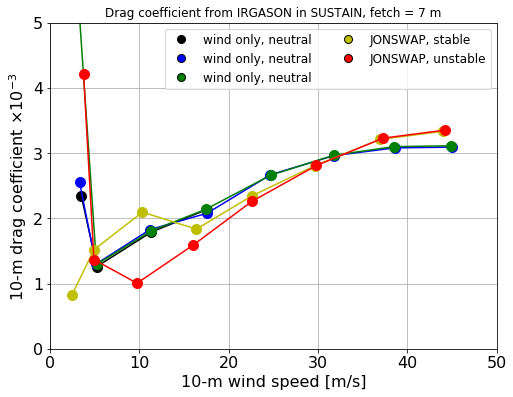

In [66]:
irgnum = '1'

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlim=(0, 50), ylim=(0, 5))
ax.tick_params(axis='both', labelsize=16)

for nexp, exp in enumerate(experiments):
    plt.plot(np.nan, np.nan, colors[nexp] + 'o', mec='k', ms=8, label=labels[nexp])
    U10, Cd = [], []
    for nrun, fan in enumerate(exp['fan']):
        Uz, uw = np.nanmean(exp['U' + irgnum][nrun]), np.nanmean(exp['uw' + irgnum][nrun])
        dtaudz_exp_index = 0 if nexp < 3 else nexp - 2
        uw_sfc = uw - dtaudz[dtaudz_exp_index, nrun] * (z_irgason - z_surface)
        ust = np.sqrt(np.abs(uw))
        ust_sfc = np.sqrt(np.abs(uw_sfc))
        U10.append(scale_to_height(ust_sfc, Uz, z_irgason - z_surface, 10.))
        Cd.append(ust_sfc**2 / U10[-1]**2 * 1e3)
    plt.plot(U10, Cd, colors[nexp] + '-', marker='o', ms=10)

plt.legend(ncol=2, prop={'size': 12})
plt.grid()
plt.xlabel('10-m wind speed [m/s]', fontsize=16)
plt.ylabel(r'10-m drag coefficient $\times 10^{-3}$', fontsize=16)
plt.title('Drag coefficient from IRGASON in SUSTAIN, fetch = 7 m')

Text(0.5, 1.0, 'Drag coefficient from IRGASON in SUSTAIN, fetch = 12 m')

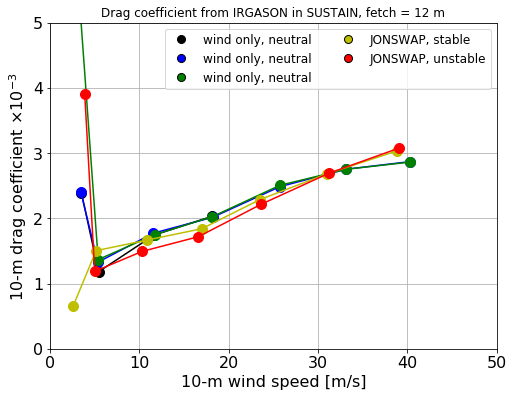

In [63]:
irgnum = '2'

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlim=(0, 50), ylim=(0, 5))
ax.tick_params(axis='both', labelsize=16)

for nexp, exp in enumerate(experiments):
    plt.plot(np.nan, np.nan, colors[nexp] + 'o', mec='k', ms=8, label=labels[nexp])
    U10, Cd = [], []
    for nrun, fan in enumerate(exp['fan']):
        Uz, uw = np.nanmean(exp['U' + irgnum][nrun]), np.nanmean(exp['uw' + irgnum][nrun])
        dtaudz_exp_index = 0 if nexp < 3 else nexp - 2
        uw_sfc = uw - dtaudz[dtaudz_exp_index, nrun] * (z_irgason - z_surface)
        ust = np.sqrt(np.abs(uw))
        ust_sfc = np.sqrt(np.abs(uw_sfc))
        U10.append(scale_to_height(ust_sfc, Uz, z_irgason - z_surface, 10.))
        Cd.append(ust_sfc**2 / U10[-1]**2 * 1e3)
    plt.plot(U10, Cd, colors[nexp] + '-', marker='o', ms=10)

plt.legend(ncol=2, prop={'size': 12})
plt.grid()
plt.xlabel('10-m wind speed [m/s]', fontsize=16)
plt.ylabel(r'10-m drag coefficient $\times 10^{-3}$', fontsize=16)
plt.title('Drag coefficient from IRGASON in SUSTAIN, fetch = 12 m')

## Putting field data, ASIST, and SUSTAIN together

In [32]:
# fresh-water
with Dataset('data/nsf-drag-2018_asist-windonly-fresh.nc') as nc:
    U10_irg_fresh = nc.variables['U10_irgason'][:]
    U10_irg_err_fresh = nc.variables['U10_irgason_error'][:]
    U10_hf_fresh = nc.variables['U10_hotwire'][:]
    U10_mb_fresh = nc.variables['U10_momentum_budget'][:]
    U10_mb_err_fresh = nc.variables['U10_momentum_budget_error'][:]
    CD_irg_fresh = nc.variables['drag_coefficient_irgason'][:]
    CD_irg_err_fresh = nc.variables['drag_coefficient_irgason_error'][:]
    CD_hf_fresh = nc.variables['drag_coefficient_hotwire'][:]
    CD_mb_fresh = nc.variables['drag_coefficient_momentum_budget'][:]
    CD_mb_err_fresh = nc.variables['drag_coefficient_momentum_budget_error'][:]
    
# seawater
with Dataset('data/nsf-drag-2018_asist-windonly-salt.nc') as nc:
    U10_irg_salt = nc.variables['U10_irgason'][:]
    U10_irg_err_salt = nc.variables['U10_irgason_error'][:]
    U10_hf_salt = nc.variables['U10_hotwire'][:]
    U10_mb_salt = nc.variables['U10_momentum_budget'][:]
    U10_mb_err_salt = nc.variables['U10_momentum_budget_error'][:]
    CD_irg_salt = nc.variables['drag_coefficient_irgason'][:]
    CD_irg_err_salt = nc.variables['drag_coefficient_irgason_error'][:]
    CD_hf_salt = nc.variables['drag_coefficient_hotwire'][:]
    CD_mb_salt = nc.variables['drag_coefficient_momentum_budget'][:]
    CD_mb_err_salt = nc.variables['drag_coefficient_momentum_budget_error'][:]

In [33]:
# pitot @ 30 cm
mat = loadmat('data/hidrag/uwvsu2-24.mat')
U_pitot_d04 = mat['ups'][0]

# momentum budget
mat = loadmat('data/hidrag/dragplt2.mat')
U10_mb_d04, CD_mb_d04 = mat['U10CD'][0], mat['CD'][0]

# correct momentum budget
VON_KARMAN = 0.4
ust = np.sqrt(CD_mb_d04) * U10_mb_d04
U10_mb_d04_corrected = U_pitot_d04 + ust / VON_KARMAN * np.log(10 / 0.3)
CD_mb_d04_corrected = ust**2 / U10_mb_d04_corrected**2

# Hot film
mat = loadmat('data/hidrag/uwcd.mat')
U10_hf_d04, CD_hf_d04 = mat['U10uw'][0], mat['cduw'][0]

# correct hot film
ust = np.sqrt(CD_hf_d04) * U10_hf_d04
U10_hf_d04_corrected = U_pitot_d04 + ust / VON_KARMAN * np.log(10 / 0.3)
CD_hf_d04_corrected = ust**2 / U10_hf_d04_corrected**2

# load field data from file
f = [x.strip().split() for x in open('data/edson_etal_2013.txt').readlines()][1:]
U10_e13 = np.array([float(x[0]) for x in f])
CD_e13 = np.array([float(x[1]) for x in f])
CD_e13_std = np.array([float(x[2]) for x in f])

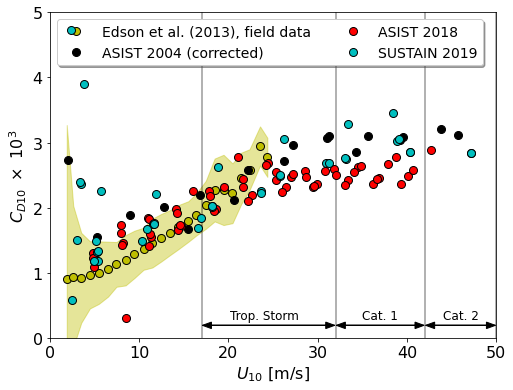

In [34]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlim=(0, 50), ylim=(0, 5))
ax.tick_params(axis='both', labelsize=16)

for wspd in [17, 32, 42, 50, 58]:
    plt.plot([wspd, wspd], [0, 5], 'k-', lw=2, alpha=0.3)

plt.arrow(17.1, 0.2, 14.8, 0, color='k', head_length=1, head_width=0.1, length_includes_head=True)
plt.arrow(31.9, 0.2, -14.8, 0, color='k', head_length=1, head_width=0.1, length_includes_head=True)

plt.arrow(32.1, 0.2, 9.8, 0, color='k', head_length=1, head_width=0.1, length_includes_head=True)
plt.arrow(41.9, 0.2, -9.8, 0, color='k', head_length=1, head_width=0.1, length_includes_head=True)

plt.arrow(42.1, 0.2, 7.8, 0, color='k', head_length=1, head_width=0.1, length_includes_head=True)
plt.arrow(49.9, 0.2, -7.8, 0, color='k', head_length=1, head_width=0.1, length_includes_head=True)

plt.arrow(50.1, 0.2, 7.8, 0, color='k', head_length=1, head_width=0.1, length_includes_head=True)
plt.arrow(57.9, 0.2, -7.8, 0, color='k', head_length=1, head_width=0.1, length_includes_head=True)

plt.text(24, 0.3, 'Trop. Storm', ha='center', fontsize=12)
plt.text(37, 0.3, 'Cat. 1', ha='center', fontsize=12)
plt.text(46, 0.3, 'Cat. 2', ha='center', fontsize=12)
#plt.text(54, 0.3, 'Cat. 3', ha='center', fontsize=12)

# Edson et al. (2013)
plt.plot(U10_e13, CD_e13, color='y', marker='o', ms=8, mec='k', linestyle='')
plt.fill_between(U10_e13, CD_e13 - CD_e13_std, CD_e13 + CD_e13_std, color='y', alpha=0.4)

plt.plot(U10_hf_fresh, CD_hf_fresh * 1e3, 'ro', ms=8, mec='k', zorder=10) # hotfilm
plt.errorbar(U10_mb_fresh, CD_mb_fresh * 1e3, yerr=0 * CD_mb_err_fresh * 1e3, color='r', marker='o', 
             ms=8, lw=0.6, mec='k', linestyle='', zorder=10)
plt.errorbar(U10_irg_fresh, CD_irg_fresh * 1e3, yerr=0 * CD_irg_err_fresh * 1e3, color='r', marker='o', 
             ms=8, lw=0.6, mec='k', linestyle='', zorder=10)

plt.plot(U10_hf_salt, CD_hf_salt * 1e3, 'ro', ms=8, mec='k', zorder=10) # hotfilm
plt.errorbar(U10_mb_salt, CD_mb_salt * 1e3, yerr=0 * CD_mb_err_salt * 1e3, color='r', marker='o', 
             ms=8, lw=0.6, mfc='r', mec='k', linestyle='', zorder=10)
plt.errorbar(U10_irg_salt, CD_irg_salt * 1e3, yerr=0 * CD_irg_err_salt * 1e3, color='r', marker='o', 
             ms=8, lw=0.6, mfc='r', mec='k', linestyle='', zorder=10)

#plt.plot(U10_hf_d04[:-2], CD_hf_d04[:-2] * 1e3, 'k^', ms=8)
#plt.plot(U10_mb_d04[4:], CD_mb_d04[4:] * 1e3, 'k.', ms=14)
plt.plot(U10_hf_d04_corrected[:-2], CD_hf_d04_corrected[:-2] * 1e3, 'ko', ms=8)
plt.plot(U10_mb_d04_corrected[4:], CD_mb_d04_corrected[4:] * 1e3, 'ko', ms=8)

irgnum = '2'
for nexp, exp in enumerate(experiments):
    U10, Cd = [], []
    for nrun, fan in enumerate(exp['fan']):
        Uz, uw = np.nanmean(exp['U' + irgnum][nrun]), np.nanmean(exp['uw' + irgnum][nrun])
        dtaudz_exp_index = 0 if nexp < 3 else nexp - 2
        uw_sfc = uw - dtaudz[dtaudz_exp_index, nrun] * (z_irgason - z_surface)
        ust = np.sqrt(np.abs(uw))
        ust_sfc = np.sqrt(np.abs(uw_sfc))
        U10.append(scale_to_height(ust_sfc, Uz, z_irgason - z_surface, 10.))
        Cd.append(ust_sfc**2 / U10[-1]**2 * 1e3)
    plt.plot(U10, Cd, 'co', marker='o', mec='k', ms=8, zorder=20)

plt.plot(np.nan, np.nan, 'yo', ms=8, mec='k', label='Edson et al. (2013), field data')
plt.plot(np.nan, np.nan, 'ko', ms=8, mec='k', label='ASIST 2004 (corrected)')
plt.plot(np.nan, np.nan, 'ro', ms=8, mec='k', label='ASIST 2018')
plt.plot(np.nan, np.nan, 'co', ms=8, mec='k', label='SUSTAIN 2019')
plt.legend(loc='upper left', fancybox=True, shadow=True, ncol=2, prop={'size': 14})
    
    
plt.xlabel(r'$U_{10}$ [m/s]', fontsize=16)
plt.ylabel(r'$C_{D10}\ \times\ 10^3$', fontsize=16)

plt.savefig('cd_asist_sustain_all.png', dpi=300)